In [1]:
import os
import time
from tqdm.notebook import tqdm
from scipy.special import hyp2f1, factorial, comb
from sympy.functions.combinatorial.numbers import stirling
from math import atan, cos, sin
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def get_centroid(img):
    
    h, w = img.shape

    m00 = img.sum()

    y = np.repeat(np.expand_dims(np.array(range(h)), 1), w, 1)
    m01 = np.multiply(y, img).sum()

    x = np.repeat(np.expand_dims(np.array(range(w)), 0), h, 0)
    m10 = np.multiply(x, img).sum()

    x_c = int(m10 // m00)
    y_c = int(m01 // m00)

    return x_c, y_c

def get_central_moment(img, a, b):
    h, w = img.shape
    x_c, y_c = get_centroid(f)
    x = ((np.array(range(w)) - x_c) ** a).astype('int64')
    y = ((np.array(range(h)) - y_c) ** b).astype('int64')
    x, y = np.meshgrid(x, y)
    retval = np.multiply(x, y)
    retval = np.multiply(retval, img.astype('int64'))
    return np.sum(retval)

In [3]:
# fname = '../data/shufadict/clean/里/00ae48086c117ff5999fb71cbf157d4d.png'
# fname = '../data/shufadict/clean/里/3a51dfccf8a32b3a1e0a386488a986b4.png'
# fname = '../data/shufadict/clean/里/f078d6b3aad77c232e497a1dc2fc9070.png'
# fname = '../data/shufadict/clean/也/49ad5ddd4dfd11874212f56d02d88355.png'
fname = '../data/shufadict/clean/也/bb3c44d77c1568d478b3ff87ebf2bf44.png'
# fname = '/Users/kx/desktop/2.png'

In [4]:
f = (cv2.imread(fname)[:, :, 0] // 255).astype('uint8')

N, M = 64, 64
f = cv2.resize(f, (N, M))

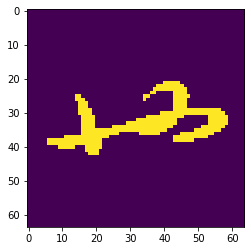

In [5]:
plt.imshow(f)

In [6]:
memo_K = np.empty((max(N, M) * 2 + 1, max(N, M) * 2 + 1))
memo_K[:] = np.nan

def K(n, x, p, N):
    if np.isnan(memo_K[n, x]):
        memo_K[n, x] = hyp2f1(-n, -x, -N, 1/p)
        if np.isnan(memo_K[n, x]):
            memo_K[n, x] = 0
    return memo_K[n, x]

In [7]:
memo_tilda_K = np.empty((N * 2 + 1, M * 2 + 1))
memo_c = np.empty((max(N, M) * 2 + 1, max(N, M) * 2 + 1))
memo_d = np.empty((max(N, M) * 2 + 1, max(N, M) * 2 + 1))
memo_d[:] = np.nan
memo_c[:] = np.nan
memo_tilda_K[:] = np.nan


def tilda_K(n, m, f, p):
    if np.isnan(memo_tilda_K[n, m]):
        N, M = f.shape
        memo_tilda_K[n, m] = 0
        for x in range(N):
            for y in range(M):
                memo_tilda_K[n, m] += f[x, y] * K(n, x, p, N) * K(m, y, p, M)
    return memo_tilda_K[n, m]


def c(n, i, N, p):
    if np.isnan(memo_c[n, i]):
        memo_c[n, i] = 0
        for k in range(i, n + 1):
            num = (-1 ** k) * factorial(n) * factorial(N - k)
            denom = (p ** k) * factorial(N) * factorial(k) * factorial(n - k)
            memo_c[n, i] += num / denom * stirling(k, i, kind=1)
    return memo_c[n, i]


def d(i, s, N, p):
    if np.isnan(memo_d[i, s]):
        memo_d[i, s] = 0
        for m in range(s, i + 1):
            num = (-1 ** s) * factorial(m) * factorial(N) * (p ** m)
            denom = factorial(m - s) * factorial(N - m) * factorial(m)
            memo_d[i, s] += stirling(i, m, kind=2) * num / (denom + 1e-100) # TODO
            

    return memo_d[i, s]

In [8]:
def Irs(n, m, f, p):
    
    N, M = f.shape
    
    u = 2 * get_central_moment(f, 2, 2) * get_central_moment(f, 0, 0) / (get_central_moment(f, 1, 1) ** 2)
    v = 2 * get_central_moment(f, 2, 2) * (get_central_moment(f, 1, 0) ** 2) / (get_central_moment(f, 0, 0) * (get_central_moment(f, 1, 1) ** 2))

    delta_f = tilda_K(0, 0, f, 0.5)
    theta_f = 0.5 * atan(
        (u * tilda_K(1, 1, f, 0.5) - u * tilda_K(0, 0, f, 0.5)) / 
        (tilda_K(2, 0, f, 0.5) - tilda_K(0, 2, f, 0.5))
    )
    cos_theta_f = cos(theta_f)
    sin_theta_f = sin(theta_f)
    Irs_nm = 0

    for i in range(n + 1):
        
        term4 = c(n, i, N, p)
        
        for j in range(m + 1):
            
            term5 = c(m, j, N, p)
            term8 = delta_f ** (- (i + j + 2) / 2)
            
            for s in range(i + 1):
                
                term2 = comb(i, s, exact=True)
                
                for t in range(j + 1):
                    term1 = (-1) ** (j - t)
                    term3 = comb(j, t, exact=True)
                    term9 = cos_theta_f ** (i + t - s)
                    term10 = sin_theta_f ** (j - t + s)
                    
                    for bb in range(0, s + t + 1):
                        d(s + t, bb, N, p)
                    for bb in range(0, i + j - s - t + 1):
                        d(i + j - s - t, bb, N, p)
                    term7 = memo_d[s + t, 0:s + t + 1]
                    term6 = memo_d[i + j - s - t, 0:i + j - s - t + 1]

                    term7, term6 = np.meshgrid(term7, term6)
                    
                    for aa in range(0, i + j - s - t + 1):
                        for bb in range(0, s + t + 1):
                            tilda_K(aa, bb, f, p)
                    term11 = memo_tilda_K[0:i + j - s - t + 1, 0:s + t + 1]
                    
                    term6_7_11 = np.multiply(term6, term7)
                    term6_7_11 = np.multiply(term6_7_11, term11)
                    term6_7_11 = np.sum(term6_7_11)
                    
                    tmp = term1 * \
                        term2 * \
                        term3 * \
                        term4 * term5 * \
                        term8 * \
                        term9 * \
                        term10 * \
                        term6_7_11
                    Irs_nm += tmp

    return Irs_nm

In [9]:
tik = time.time()

Q = np.empty((N, M))
Q[:] = np.nan
order = 4

for i in tqdm(range(order)):
    for j in range(order):
        Q[i, j] = Irs(i, j, f, p=0.5)
        
tok = time.time()
print(tok - tik)

  0%|          | 0/4 [00:00<?, ?it/s]

0.7745909690856934


In [10]:
Q[:4, :4]

array([[1.        , 0.99897785, 0.99699309, 0.99393414],
       [1.07399261, 1.07322406, 1.07147216, 1.0686227 ],
       [1.15478898, 1.15430206, 1.15281033, 1.15019682],
       [1.24319707, 1.24302337, 1.24182262, 1.23947498]])